# Unintended bias analysis
In this notebook, the toxicity classifiers are evaluated in terms of their unintended bias following Dixon et al. 2018 (https://doi.org/10.1145/3278721.3278729) and Borkan et al. 2019 (https://doi.org/10.1145/3308560.3317593).

The following metrics are calculated and in some cases plotted:
* Overall AUC
* False Positive Equality Difference and False Negative Equality Difference
* Subgroup AUC
* Background Positive Subgroup Negative AUC and Background Negative Subgroup Positive AUC
* Weighted Bias Score
* Positive Average Equality Gap and Negative Average Equality Gap

In [1]:
# imports 
import bias_metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
import sys
import tensorflow as tf # tf backend
from tqdm import tqdm
from typing import Dict, List, Tuple
import warnings

NUM_MODELS = 10

## Load and predict synthetic data

In [2]:
# load synthetic data
try:
    with open(os.getcwd()+"/data/synth_data_with_preds.pkl", "rb") as f:
        synth_data = pickle.load(f)
    y_synth = synth_data["toxic"]
    print(f"{len(y_synth):,} synthetic sentences")
    display(synth_data.head())

except FileNotFoundError:
    print("Synthetic data with predictions not found. Please run file with the toxicity models to generate them.")

12,780 synthetic sentences


,text,group,identity_term,toxic,identity_lemma,baseline_proba,baseline_pred,CNNorig_proba0,CNNorig_pred0,CNNorig_proba1,...,CNNrandom_proba5,CNNrandom_pred5,CNNrandom_proba6,CNNrandom_pred6,CNNrandom_proba7,CNNrandom_pred7,CNNrandom_proba8,CNNrandom_pred8,CNNrandom_proba9,CNNrandom_pred9
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde,0.233878,0,0.870549,1,0.708808,...,0.703342,1,0.621060,1,0.850491,1,0.678381,1,0.738789,1
1,piger er klamme og generelt bare nederen,F,piger,1,pige,0.252262,0,0.904548,1,0.857611,...,0.934454,1,0.793842,1,0.938601,1,0.907379,1,0.915415,1
2,damer er klamme og generelt bare nederen,F,damer,1,dame,0.229869,0,0.881397,1,0.738381,...,0.809524,1,0.596624,1,0.830354,1,0.845452,1,0.822143,1
3,koner er klamme og generelt bare nederen,F,koner,1,kone,0.224423,0,0.872802,1,0.851048,...,0.853542,1,0.657805,1,0.906651,1,0.792409,1,0.871409,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk,0.239026,0,0.948709,1,0.954115,...,0.953974,1,0.877840,1,0.946674,1,0.927754,1,0.963432,1


## Overall AUC

In [3]:
# load preprocessed and oversampled data splits
try: 
    with open(os.getcwd()+"/data/orig_dataset_splits.pkl", "rb") as f:
        orig_data = pickle.load(f)
except OSError as e:
    print(f"Unable to open file: {e}.\nPlease run the toxicity model file to generate it.", file=sys.stderr)
    
X_train_orig = orig_data["X training preprocessed and oversampled"]
y_train_orig = orig_data["y training preprocessed and oversampled"]
X_test_orig = orig_data["X test preprocessed"]
y_test_orig = orig_data["y test"]

print("Shapes:")
print(X_train_orig.shape, y_train_orig.shape)
print(X_test_orig.shape, y_test_orig.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


### Baseline

In [4]:
# compute using baseline model (1 variants)
with open(os.getcwd()+"/data/overall_aucs_test_baseline.pkl", "rb") as f:
    overall_aucs_test_baseline = pickle.load(f) # regular dataset
overall_aucs_synth_baseline = roc_auc_score(y_synth, synth_data["baseline_proba"]) # synthetic dataset

### Original CNN

In [5]:
with open(os.getcwd()+"/data/overall_aucs_test_orig.pkl", "rb") as f:
    overall_aucs_test_orig = pickle.load(f) # regular dataset
overall_aucs_synth_orig = [roc_auc_score(y_synth, synth_data["CNNorig_proba"+str(i)]) for i in range(10)] # synthetic data set

### CDS CNN

In [6]:
with open(os.getcwd()+"/data/overall_aucs_test_CDS.pkl", "rb") as f:
    overall_aucs_test_CDS = pickle.load(f) # regular dataset
overall_aucs_synth_CDS = [roc_auc_score(y_synth, synth_data["CNNCDS_proba"+str(i)]) for i in range(10)] # synthetic data set

### Suppl. CNN

In [7]:
with open(os.getcwd()+"/data/overall_aucs_test_suppl.pkl", "rb") as f:
    overall_aucs_test_suppl = pickle.load(f) # regular dataset
overall_aucs_synth_suppl = [roc_auc_score(y_synth, synth_data["CNNsuppl_proba"+str(i)]) for i in range(10)] # synthetic data set

### Random CNN

In [8]:
with open(os.getcwd()+"/data/overall_aucs_test_random.pkl", "rb") as f:
    overall_aucs_test_random = pickle.load(f) # regular dataset
overall_aucs_synth_random = [roc_auc_score(y_synth, synth_data["CNNrandom_proba"+str(i)]) for i in range(10)] # synthetic data set

### Display results

In [9]:
# display the results in a dataframe
overall_aucs_test = {
    "Baseline, test set": {
        "M": np.mean(overall_aucs_test_baseline),
        "Mdn": np.median(overall_aucs_test_baseline),
        "SD": np.std(overall_aucs_test_baseline),
        "Max": np.max(overall_aucs_test_baseline)
        },
    "Orig. CNN, test set": {
        "M": np.mean(overall_aucs_test_orig),
        "Mdn": np.median(overall_aucs_test_orig),
        "SD": np.std(overall_aucs_test_orig),
        "Max": np.max(overall_aucs_test_orig)
        },
    "CDS CNN, test set": {
        "M": np.mean(overall_aucs_test_CDS),
        "Mdn": np.median(overall_aucs_test_CDS),
        "SD": np.std(overall_aucs_test_CDS),
        "Max": np.max(overall_aucs_test_CDS)
        },
    "Suppl. CNN, test set": {
        "M": np.mean(overall_aucs_test_suppl),
        "Mdn": np.median(overall_aucs_test_suppl),
        "SD": np.std(overall_aucs_test_suppl),
        "Max": np.max(overall_aucs_test_suppl)
        },
    "Random CNN, test set": {
        "M": np.mean(overall_aucs_test_random),
        "Mdn": np.median(overall_aucs_test_random),
        "SD": np.std(overall_aucs_test_random),
        "Max": np.max(overall_aucs_test_random)
        }
}

overall_aucs_synth = {
    "Baseline, synthetic set": {
        "M": np.mean(overall_aucs_synth_baseline),
        "Mdn": np.median(overall_aucs_synth_baseline),
        "SD": np.std(overall_aucs_synth_baseline),
        "Max": np.max(overall_aucs_synth_baseline)
        },
    "Orig. CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_orig),
        "Mdn": np.median(overall_aucs_synth_orig),
        "SD": np.std(overall_aucs_synth_orig),
        "Max": np.max(overall_aucs_synth_orig)
        },
    "CDS CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_CDS),
        "Mdn": np.median(overall_aucs_synth_CDS),
        "SD": np.std(overall_aucs_synth_CDS),
        "Max": np.max(overall_aucs_synth_CDS)
        },
    "Suppl. CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_suppl),
        "Mdn": np.median(overall_aucs_synth_suppl),
        "SD": np.std(overall_aucs_synth_suppl),
        "Max": np.max(overall_aucs_synth_suppl)
        },
    "Random CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_random),
        "Mdn": np.median(overall_aucs_synth_random),
        "SD": np.std(overall_aucs_synth_random),
        "Max": np.max(overall_aucs_synth_random)
        }
}

print("Test set:")
display(round(pd.DataFrame(overall_aucs_test), 3))

print("\n\nSynthetic test set:")
display(round(pd.DataFrame(overall_aucs_synth), 3))

Test set:


,"Baseline, test set","Orig. CNN, test set","CDS CNN, test set","Suppl. CNN, test set","Random CNN, test set"
M,0.765,0.793,0.800,0.799,0.796
Mdn,0.765,0.796,0.805,0.798,0.798
SD,0.000,0.010,0.010,0.012,0.007
Max,0.765,0.812,0.808,0.824,0.807




Synthetic test set:


,"Baseline, synthetic set","Orig. CNN, synthetic set","CDS CNN, synthetic set","Suppl. CNN, synthetic set","Random CNN, synthetic set"
M,0.575,0.715,0.704,0.735,0.734
Mdn,0.575,0.717,0.704,0.737,0.733
SD,0.000,0.011,0.006,0.015,0.013
Max,0.575,0.740,0.713,0.765,0.756


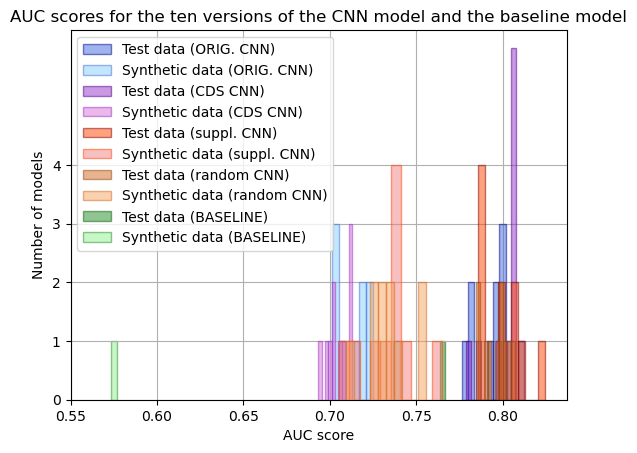

In [10]:
# plot the AUC scores (histogram)
plt.grid(zorder=1)

# orig. CNN
plt.hist(overall_aucs_test_orig, label="Test data (ORIG. CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="darkblue", color="royalblue", alpha=0.5)
plt.hist(overall_aucs_synth_orig, label="Synthetic data (ORIG. CNN)", zorder=3, bins=NUM_MODELS, edgecolor="royalblue", color="lightskyblue", alpha=0.5)

# CDS CNN
plt.hist(overall_aucs_test_CDS, label="Test data (CDS CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="indigo", color="darkorchid", alpha=0.5)
plt.hist(overall_aucs_synth_CDS, label="Synthetic data (CDS CNN)", zorder=3, bins=NUM_MODELS, edgecolor="darkorchid", color="orchid", alpha=0.5)

# Suppl. CNN
plt.hist(overall_aucs_test_suppl, label="Test data (suppl. CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="maroon", color="orangered", alpha=0.5)
plt.hist(overall_aucs_synth_suppl, label="Synthetic data (suppl. CNN)", zorder=3, bins=NUM_MODELS, edgecolor="orangered", color="lightcoral", alpha=0.5)

# Random CNN
plt.hist(overall_aucs_test_random, label="Test data (random CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="saddlebrown", color="chocolate", alpha=0.5)
plt.hist(overall_aucs_synth_random, label="Synthetic data (random CNN)", zorder=3, bins=NUM_MODELS, edgecolor="chocolate", color="sandybrown", alpha=0.5)

# baseline
plt.bar(x=overall_aucs_test_baseline, height=1, width=0.003, label="Test data (BASELINE)",edgecolor="darkgreen", color="forestgreen", alpha=0.5)
plt.bar(x=overall_aucs_synth_baseline, height=1, width=0.003, label="Synthetic data (BASELINE)", edgecolor="forestgreen", color="lightgreen", alpha=0.5)

plt.xticks(np.arange(0.55, 0.85, 0.05))
plt.yticks(np.arange(0, 5, 1))

plt.xlabel("AUC score")
plt.ylabel("Number of models")
plt.title("AUC scores for the ten versions of the CNN model and the baseline model")

plt.legend()
plt.show()

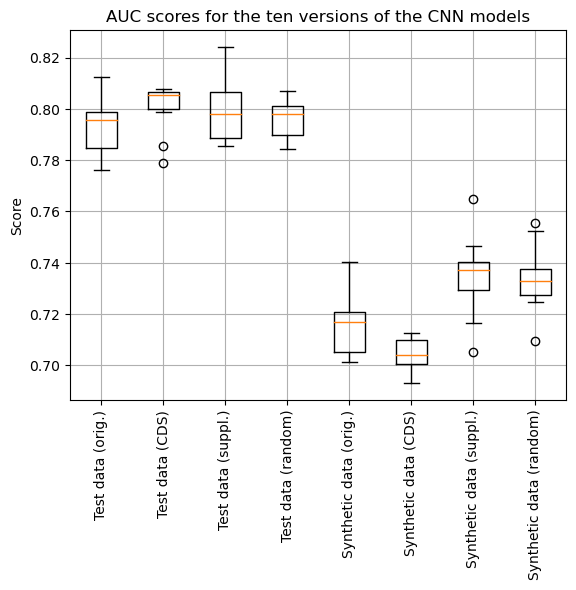

In [11]:
# plot the AUC scores (boxplot)
plt.boxplot([overall_aucs_test_orig, overall_aucs_test_CDS, overall_aucs_test_suppl, overall_aucs_test_random, overall_aucs_synth_orig, overall_aucs_synth_CDS, overall_aucs_synth_suppl, overall_aucs_synth_random])
plt.xticks(ticks=range(1,9), labels=["Test data (orig.)", "Test data (CDS)", "Test data (suppl.)", "Test data (random)", "Synthetic data (orig.)", "Synthetic data (CDS)", "Synthetic data (suppl.)", "Synthetic data (random)"], rotation=90)
#plt.ylim(0.7, 0.83)
plt.title("AUC scores for the ten versions of the CNN models")
plt.ylabel("Score")
plt.grid()
plt.show()

## FPED and FNED

### Baseline

In [12]:
# calculate per term and overall fpr and fnr for baseline model
per_term_fprs_baseline, overall_fprs_baseline = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, baseline=True)
per_term_fnrs_baseline, overall_fnrs_baseline = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, baseline=True)

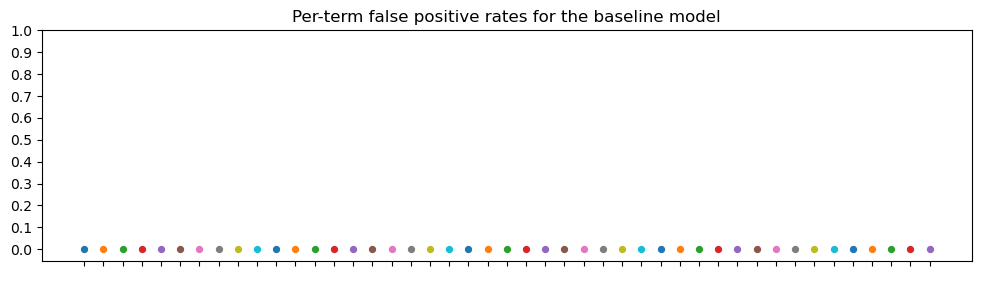

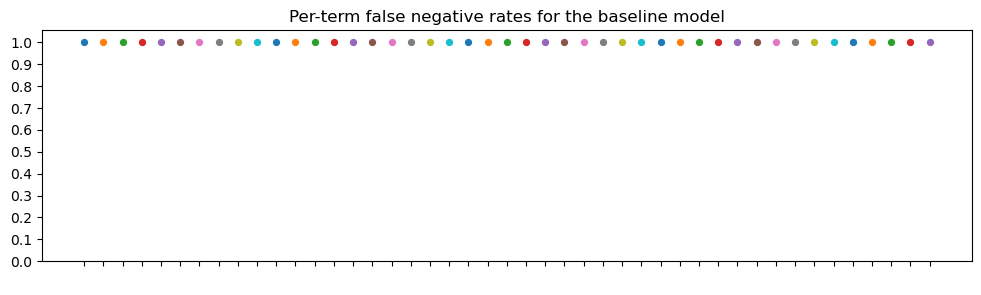

In [13]:
# Plot FPRs
plt.figure(figsize=(12,3))
#order = list(pd.DataFrame(per_term_fprs_baseline).sort_values(by="baseline", ascending=False).index)
plot_df = pd.DataFrame(per_term_fprs_baseline).T#[cnn_order_orig]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(color="w")
plt.title("Per-term false positive rates for the baseline model")
plt.savefig("plots\\FPRs_baseline2.png", bbox_inches="tight")
plt.show()

# Plot FNRs
plt.figure(figsize=(12,3))
#order = list(pd.DataFrame(per_term_fnrs_baseline).sort_values(by="baseline", ascending=False).index)
plot_df = pd.DataFrame(per_term_fnrs_baseline).T#[cnn_order2_orig]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(color="w")
plt.title("Per-term false negative rates for the baseline model")
plt.savefig("plots\\FNRs_baseline2.png", bbox_inches="tight")
plt.show()

In [14]:
# compute FPED and FNED for each model variant = overall EREDs
fpeds_baseline = bias_metrics.compute_fped(overall_fprs_baseline["baseline"], per_term_fprs_baseline["baseline"])
fneds_baseline = bias_metrics.compute_fned(overall_fnrs_baseline["baseline"], per_term_fnrs_baseline["baseline"])

# display the results in a dataframe
overall_EREDs = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_baseline),
        "Mdn": np.median(fpeds_baseline),
        "SD": np.std(fpeds_baseline),
        "Min": np.min(fpeds_baseline)
        },
    "FNED": {
        "M": np.mean(fneds_baseline),
        "Mdn": np.median(fneds_baseline),
        "SD": np.std(fneds_baseline),
        "Min": np.min(fneds_baseline)
        },
}

print("Baseline:")
display(round(pd.DataFrame(overall_EREDs),3))

Baseline:


,FPED,FNED
M,0.0,0.0
Mdn,0.0,0.0
SD,0.0,0.0
Min,0.0,0.0


### Original CNN

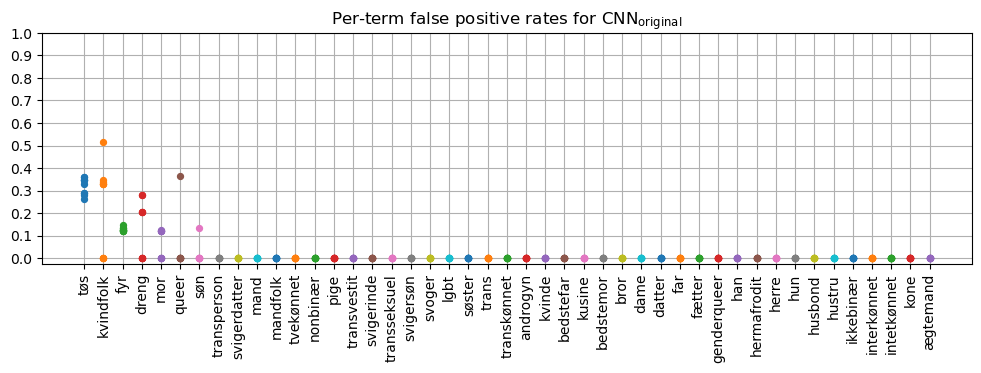

In [15]:
# calculate per term and overall fpr for CNN model
per_term_fprs_orig, overall_fprs_orig = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNorig")

# plot results
cnn_order_orig = list(pd.DataFrame(per_term_fprs_orig).mean(axis=1).sort_values(ascending=False).index)
bias_metrics.plot_per_term_metrics(per_term_fprs_orig, title="Per-term false positive rates for $\mathregular{CNN_{original}}$", save_name="FPRs_CNN_orig.png", order=cnn_order_orig, grid=True)

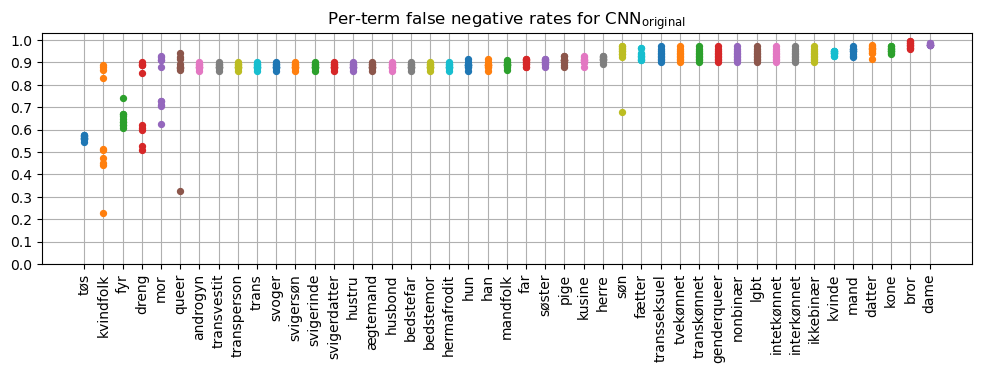

In [16]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_orig, overall_fnrs_orig = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNorig")

# plot results
cnn_order2_orig = list(pd.DataFrame(per_term_fnrs_orig).mean(axis=1).sort_values(ascending=True).index)
bias_metrics.plot_per_term_metrics(per_term_fnrs_orig, title="Per-term false negative rates for $\mathregular{CNN_{original}}$", save_name="FNRs_CNN_orig.png", order=cnn_order2_orig, grid=True)

In [17]:
# compute FPED and FNED for each model variant
fpeds_orig = [bias_metrics.compute_fped(overall_fprs_orig[str(i)], per_term_fprs_orig[str(i)]) for i in range(10)]
fneds_orig = [bias_metrics.compute_fned(overall_fnrs_orig[str(i)], per_term_fnrs_orig[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_orig = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_orig),
        "Mdn": np.median(fpeds_orig),
        "SD": np.std(fpeds_orig),
        "Min": np.min(fpeds_orig)
        },
    "FNED": {
        "M": np.mean(fneds_orig),
        "Mdn": np.median(fneds_orig),
        "SD": np.std(fneds_orig),
        "Min": np.min(fneds_orig)
        },
}

print("CNN (orig.):")
display(round(pd.DataFrame(overall_EREDs_orig),3))

CNN (orig.):


,FPED,FNED
M,1.618,2.490
Mdn,1.641,2.365
SD,0.613,0.687
Min,0.875,1.709


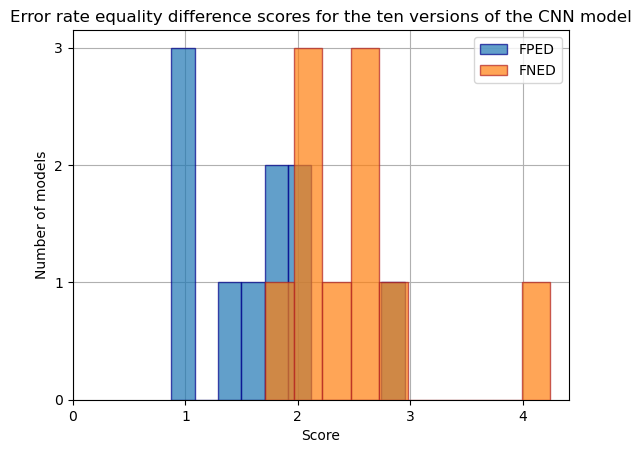

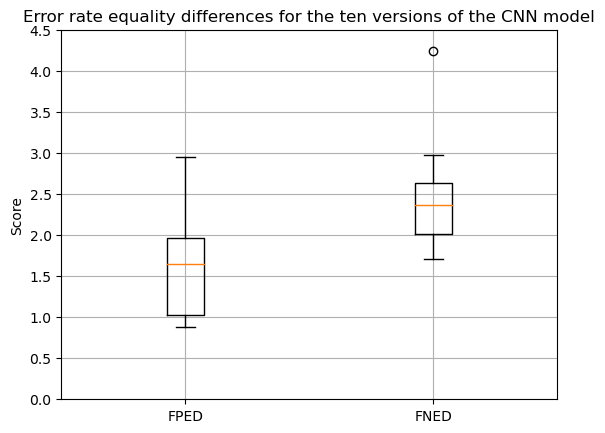

In [18]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_orig, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_orig, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_orig, fneds_orig])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

### CDS CNN

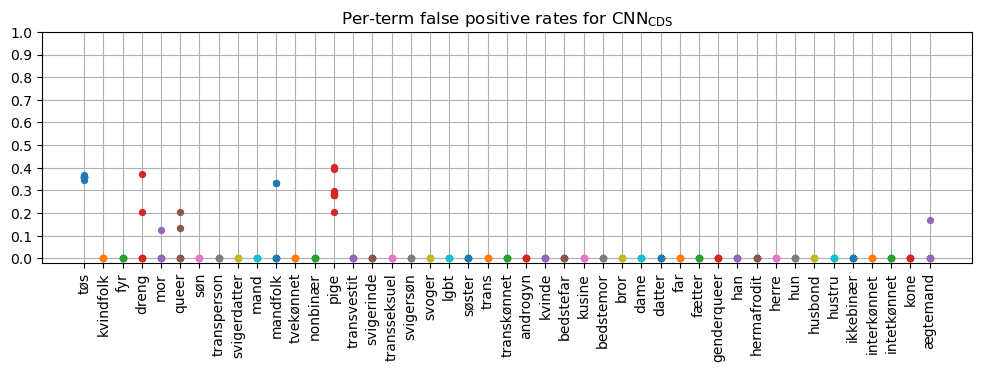

In [19]:
# calculate per term and overall fpr for CNN model
per_term_fprs_CDS, overall_fprs_CDS = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNCDS")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fprs_CDS, title="Per-term false positive rates for $\mathregular{CNN_{CDS}}$", save_name="FPRs_CNN_CDS.png", order=cnn_order_orig, grid=True)

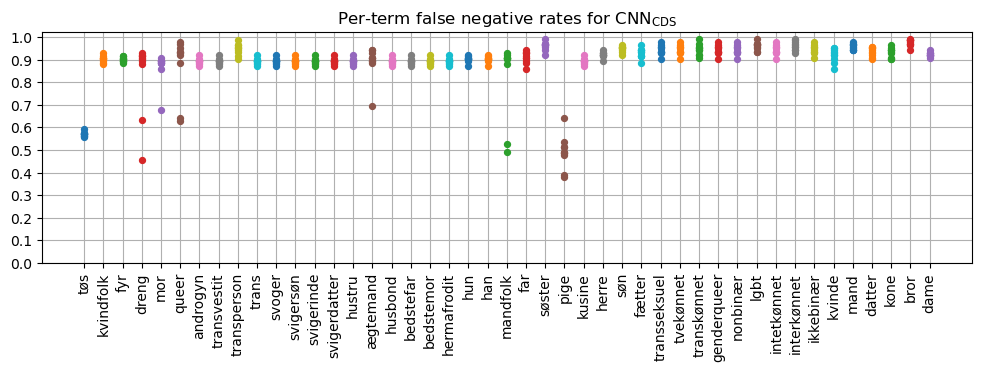

In [20]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_CDS, overall_fnrs_CDS = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNCDS")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fnrs_CDS, title="Per-term false negative rates for $\mathregular{CNN_{CDS}}$", save_name="FNRs_CNN_CDS.png", order=cnn_order2_orig, grid=True)

In [21]:
# compute FPED and FNED for each model variant
fpeds_CDS = [bias_metrics.compute_fped(overall_fprs_CDS[str(i)], per_term_fprs_CDS[str(i)]) for i in range(10)]
fneds_CDS = [bias_metrics.compute_fned(overall_fnrs_CDS[str(i)], per_term_fnrs_CDS[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_CDS = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_CDS),
        "Mdn": np.median(fpeds_CDS),
        "SD": np.std(fpeds_CDS),
        "Min": np.min(fpeds_CDS)
        },
    "FNED": {
        "M": np.mean(fneds_CDS),
        "Mdn": np.median(fneds_CDS),
        "SD": np.std(fneds_CDS),
        "Min": np.min(fneds_CDS)
        },
}

print("CNN (CDS):")
display(round(pd.DataFrame(overall_EREDs_CDS),3))

CNN (CDS):


,FPED,FNED
M,1.574,2.182
Mdn,1.342,2.152
SD,0.482,0.481
Min,1.077,1.389


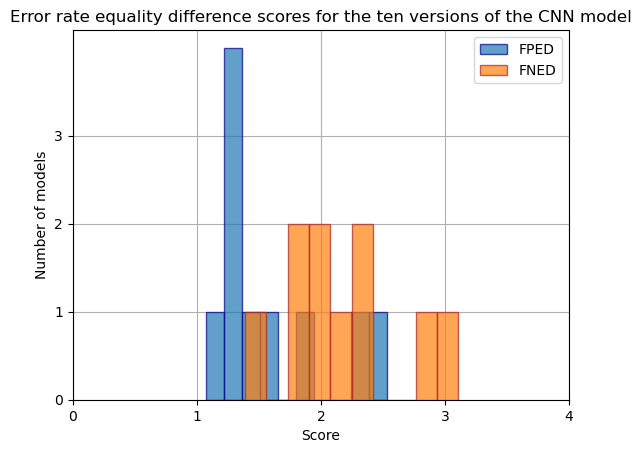

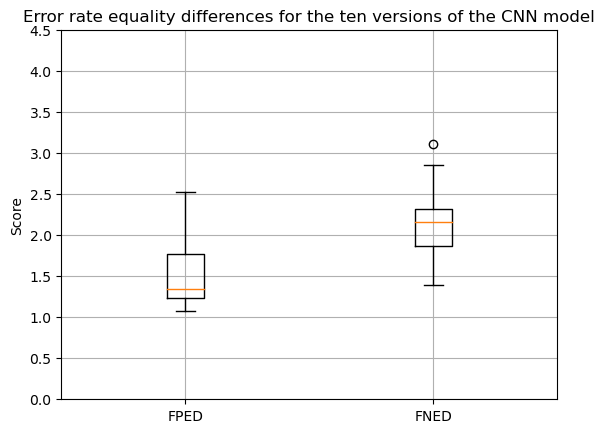

In [22]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_CDS, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_CDS, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_CDS, fneds_CDS])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

### Suppl. CNN

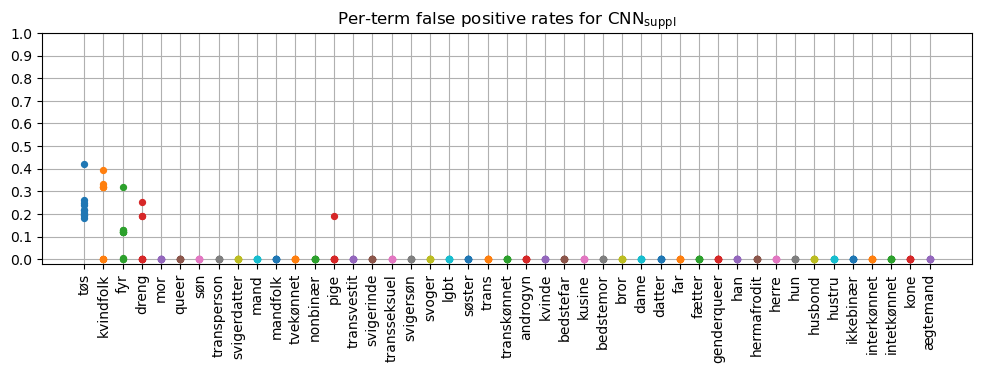

In [23]:
# calculate per term and overall fpr for CNN model
per_term_fprs_suppl, overall_fprs_suppl = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNsuppl")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fprs_suppl, title="Per-term false positive rates for $\mathregular{CNN_{suppl}}$", save_name="FPRs_CNN_suppl.png", order=cnn_order_orig, grid=True)

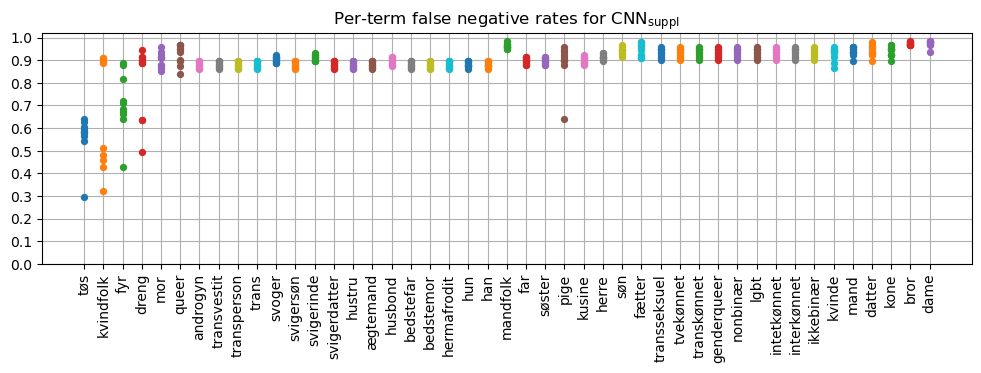

In [25]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_suppl, overall_fnrs_suppl = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNsuppl")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fnrs_suppl, title="Per-term false negative rates for $\mathregular{CNN_{suppl}}$", save_name="FNRs_CNN_suppl.png", order=cnn_order2_orig, grid=True)

In [26]:
# compute FPED and FNED for each model variant
fpeds_suppl = [bias_metrics.compute_fped(overall_fprs_suppl[str(i)], per_term_fprs_suppl[str(i)]) for i in range(10)]
fneds_suppl = [bias_metrics.compute_fned(overall_fnrs_suppl[str(i)], per_term_fnrs_suppl[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_suppl = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_suppl),
        "Mdn": np.median(fpeds_suppl),
        "SD": np.std(fpeds_suppl),
        "Min": np.min(fpeds_suppl)
        },
    "FNED": {
        "M": np.mean(fneds_suppl),
        "Mdn": np.median(fneds_suppl),
        "SD": np.std(fneds_suppl),
        "Min": np.min(fneds_suppl)
        },
}

print("CNN (suppl):")
display(round(pd.DataFrame(overall_EREDs_suppl),3))

CNN (suppl):


,FPED,FNED
M,1.098,2.110
Mdn,0.828,1.887
SD,0.651,0.648
Min,0.358,1.287


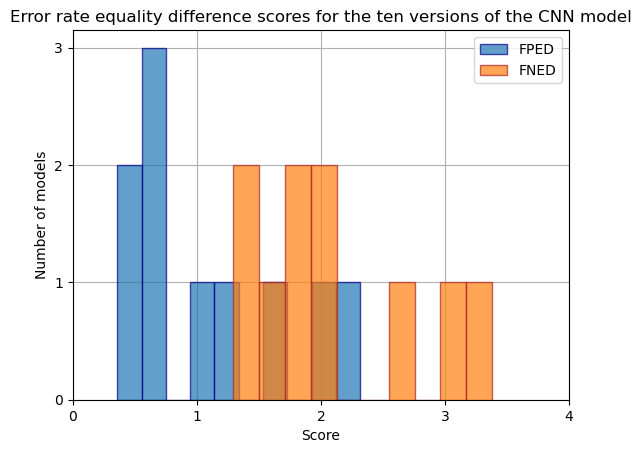

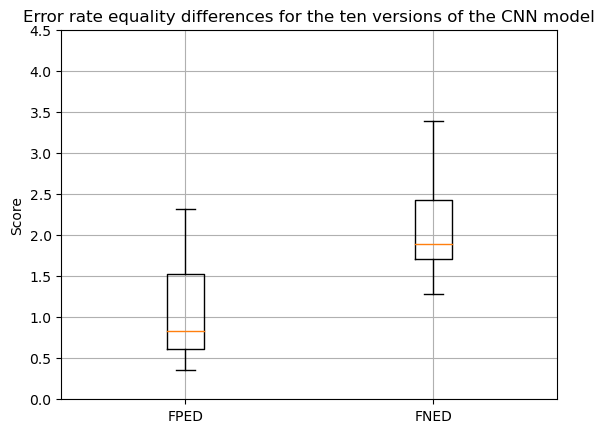

In [27]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_suppl, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_suppl, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_suppl, fneds_suppl])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

### Random CNN

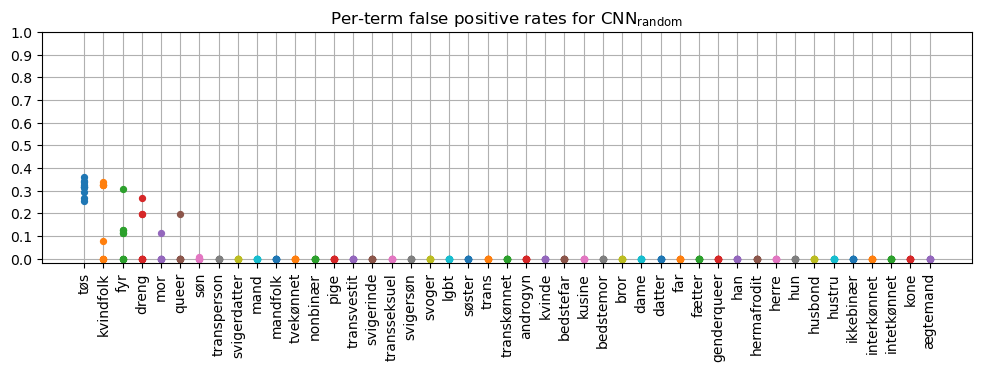

In [28]:
# calculate per term and overall fpr for CNN model
per_term_fprs_random, overall_fprs_random = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNrandom")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fprs_random, title="Per-term false positive rates for $\mathregular{CNN_{random}}$", save_name="FPRs_CNN_random.png", order=cnn_order_orig, grid=True)

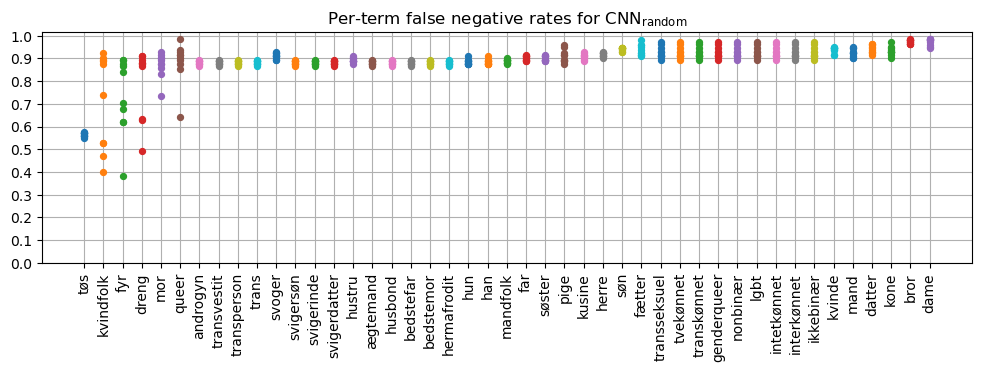

In [29]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_random, overall_fnrs_random = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNrandom")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fnrs_random, title="Per-term false negative rates for $\mathregular{CNN_{random}}$", save_name="FNRs_CNN_random.png", order=cnn_order2_orig, grid=True)

In [30]:
# compute FPED and FNED for each model variant
fpeds_random = [bias_metrics.compute_fped(overall_fprs_random[str(i)], per_term_fprs_random[str(i)]) for i in range(10)]
fneds_random = [bias_metrics.compute_fned(overall_fnrs_random[str(i)], per_term_fnrs_random[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_random = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_random),
        "Mdn": np.median(fpeds_random),
        "SD": np.std(fpeds_random),
        "Min": np.min(fpeds_random)
        },
    "FNED": {
        "M": np.mean(fneds_random),
        "Mdn": np.median(fneds_random),
        "SD": np.std(fneds_random),
        "Min": np.min(fneds_random)
        },
}

print("CNN (random):")
display(round(pd.DataFrame(overall_EREDs_random),3))

CNN (random):


,FPED,FNED
M,1.169,1.923
Mdn,1.062,1.841
SD,0.568,0.593
Min,0.496,1.185


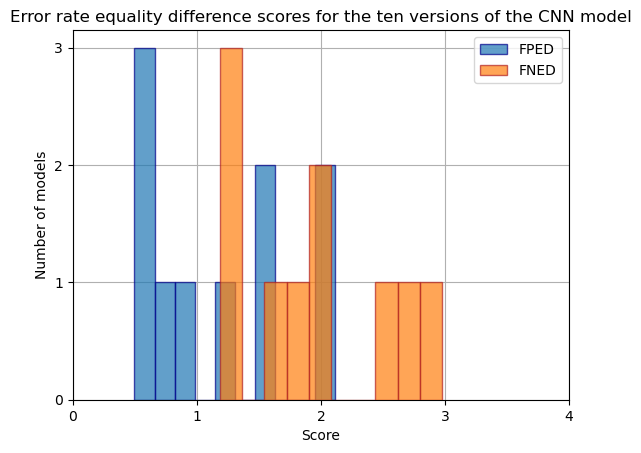

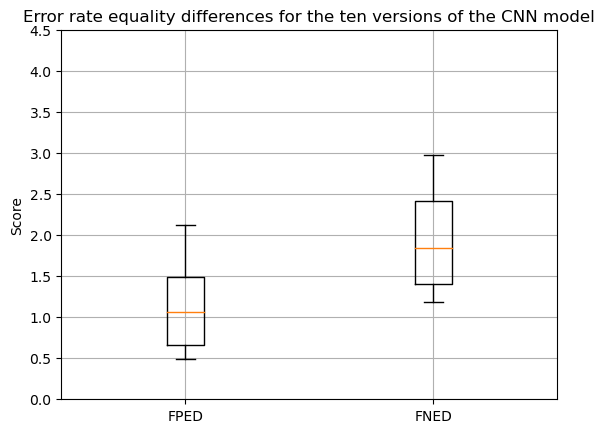

In [31]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_random, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_random, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_random, fneds_random])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

## AUC and AEG scores (termwise metrics)

In [32]:
# create custom cmaps
colors = [(0, 0, 0), (0.2, 0, 0.2), (0.7, 0.4, 0.5), (0.8, 0.6, 0.7), (0.85, 0.85, 0.85), (1, 1, 1)]
AUC_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
AEG_cmap = plt.get_cmap('PiYG', 11)

### Baseline

In [33]:
# BASELINE
# for each term, calculate scores for each model variant, and take the average

per_term_scores_baseline = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": roc_auc_score(t_df["toxic"], t_df["baseline_proba"]),
        "BPSN_avg": roc_auc_score(bpsn_df["toxic"], bpsn_df["baseline_proba"]),
        "BNSP_avg": roc_auc_score(bnsp_df["toxic"], bnsp_df["baseline_proba"]),
        "posAEG_avg": bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="baseline_proba"),
        "negAEG_avg": bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="baseline_proba")
    }
    
    per_term_scores_baseline[t_name] = scores

100%|██████████| 45/45 [00:03<00:00, 12.49it/s]


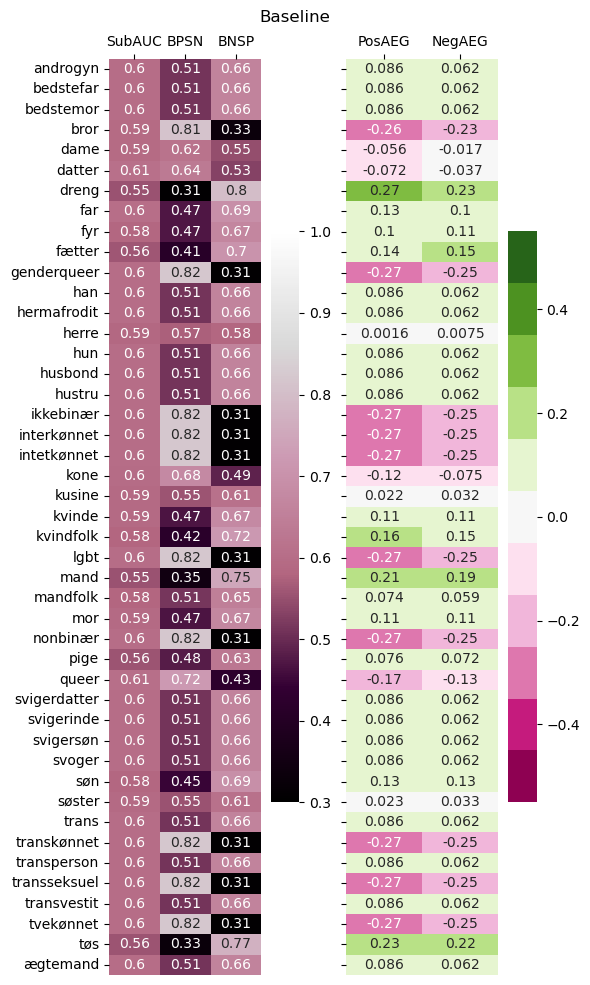

In [34]:
score_df_baseline = pd.DataFrame(per_term_scores_baseline).T
score_df_baseline.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_baseline = pd.DataFrame(score_df_baseline.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_baseline, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_baseline = pd.DataFrame(score_df_baseline.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_baseline, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Baseline")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_baseline.png", bbox_inches="tight")
plt.show()

### Original CNN

In [35]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_orig = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNorig_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNorig_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNorig_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNorig_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNorig_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_orig[t_name] = scores

100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


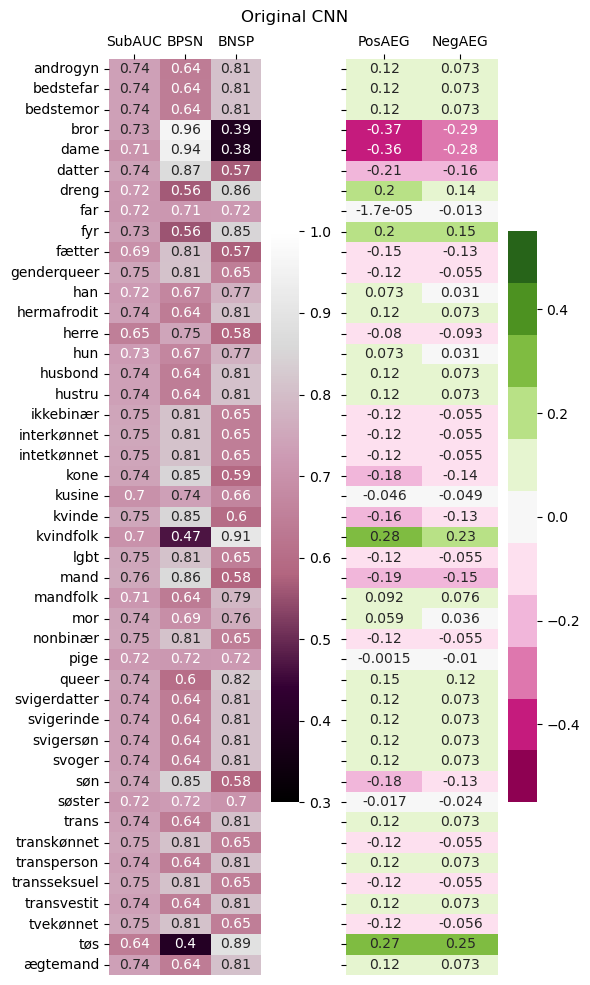

In [36]:
# plot avgs
score_df_orig = pd.DataFrame(per_term_scores_orig).T
score_df_orig.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_orig = pd.DataFrame(score_df_orig.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_orig, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_orig = pd.DataFrame(score_df_orig.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_orig, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Original CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_orig.png", bbox_inches="tight")
plt.show()

In [26]:
# # plot maxs
# score_df_orig = pd.DataFrame(per_term_scores_orig).T
# score_df_orig.rename(columns={"subAUC_max":"SubAUC", "BPSN_max": "BPSN", "BNSP_max": "BNSP", "posAEG_max": "PosAEG", "negAEG_max": "NegAEG"}, inplace=True)
# fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

# AUC_df_orig = pd.DataFrame(score_df_orig.loc[:,"SubAUC":"BNSP"], dtype="float")
# sns.heatmap(AUC_df_orig, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

# AEG_df_orig = pd.DataFrame(score_df_orig.loc[:,"PosAEG":"NegAEG"], dtype="float") # TODO max is not "retvisende" for these as it is the best result for aegs < 0 (closer to 0), but not for those > 0 (farther from 0)
# sns.heatmap(AEG_df_orig, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

# axes[0].xaxis.tick_top()
# axes[1].xaxis.tick_top()

# plt.suptitle("Original CNN")
# plt.tight_layout()
# plt.savefig("plots\\per_term_metrics_CNN_orig.png", bbox_inches="tight")
# plt.show()

### CDS CNN

In [37]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_CDS = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNCDS_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNCDS_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNCDS_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNCDS_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNCDS_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_CDS[t_name] = scores

100%|██████████| 45/45 [00:16<00:00,  2.81it/s]


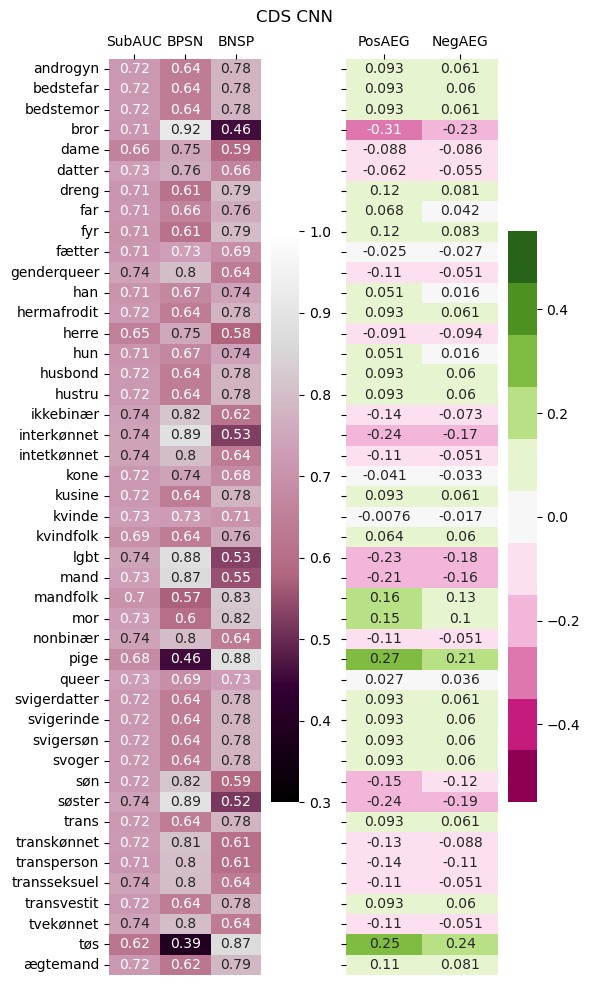

In [38]:
# plot avgs
score_df_CDS = pd.DataFrame(per_term_scores_CDS).T
score_df_CDS.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_CDS, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_CDS, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("CDS CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_CDS.png", bbox_inches="tight")
plt.show()

In [29]:
# # plot maxs
# score_df_CDS = pd.DataFrame(per_term_scores_CDS).T
# score_df_CDS.rename(columns={"subAUC_max":"SubAUC", "BPSN_max": "BPSN", "BNSP_max": "BNSP", "posAEG_max": "PosAEG", "negAEG_max": "NegAEG"}, inplace=True)
# fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

# AUC_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"SubAUC":"BNSP"], dtype="float")
# sns.heatmap(AUC_df_CDS, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

# AEG_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"PosAEG":"NegAEG"], dtype="float") # TODO max is not "retvisende" for these as it is the best result for aegs < 0 (closer to 0), but not for those > 0 (farther from 0)
# sns.heatmap(AEG_df_CDS, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

# axes[0].xaxis.tick_top()
# axes[1].xaxis.tick_top()

# plt.suptitle("CDS CNN")
# plt.tight_layout()
# plt.savefig("plots\\per_term_metrics_CNN_CDS.png", bbox_inches="tight")
# plt.show()

### Suppl. CNN

In [39]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_suppl = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNsuppl_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNsuppl_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNsuppl_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNsuppl_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNsuppl_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_suppl[t_name] = scores

100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


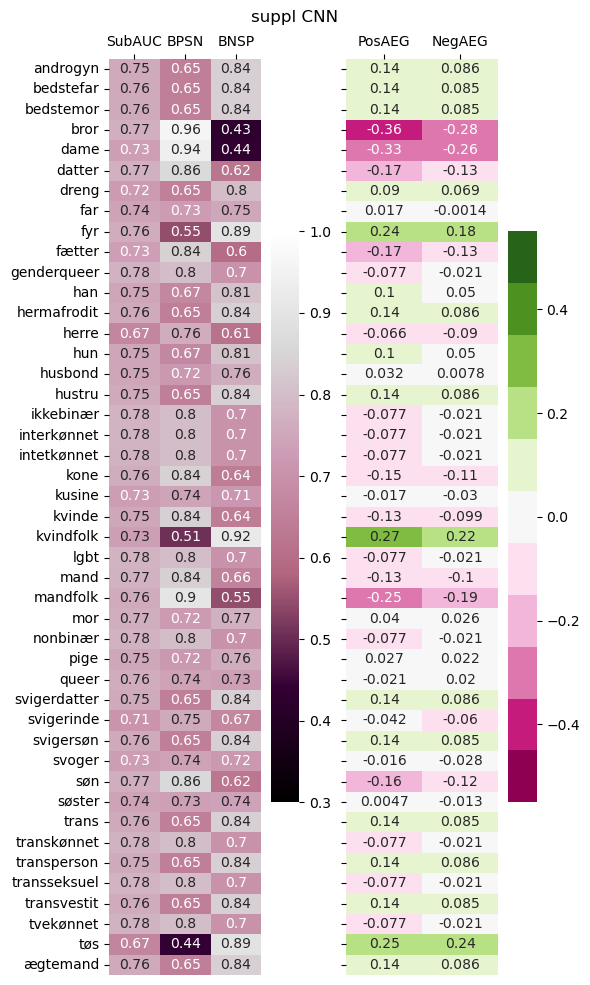

In [40]:
# plot avgs
score_df_suppl = pd.DataFrame(per_term_scores_suppl).T
score_df_suppl.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_suppl = pd.DataFrame(score_df_suppl.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_suppl, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_suppl = pd.DataFrame(score_df_suppl.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_suppl, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("suppl CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_suppl.png", bbox_inches="tight")
plt.show()

### Random CNN

In [41]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_random = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNrandom_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNrandom_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNrandom_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNrandom_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNrandom_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_random[t_name] = scores

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


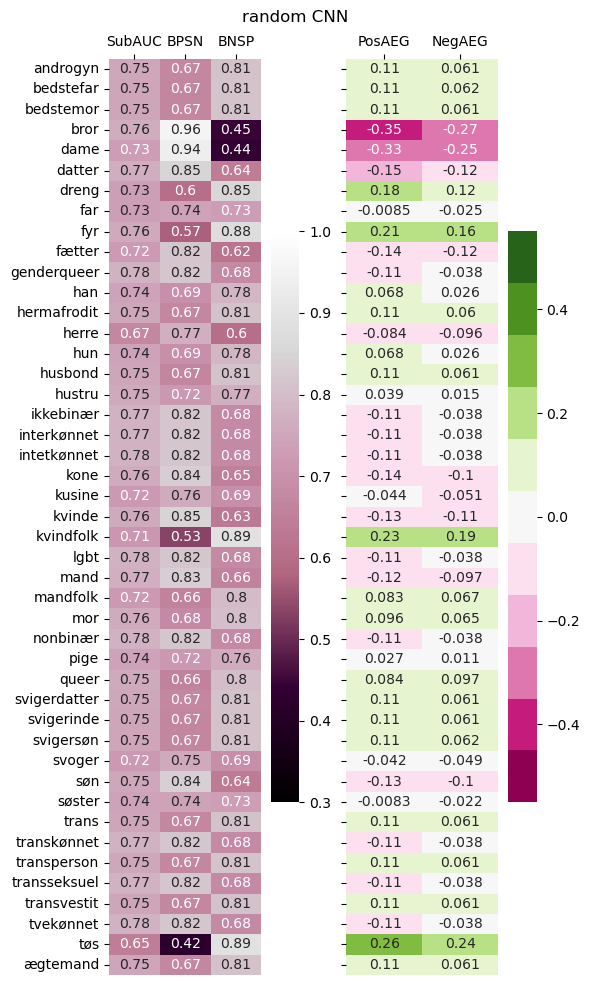

In [42]:
# plot avgs
score_df_random = pd.DataFrame(per_term_scores_random).T
score_df_random.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_random = pd.DataFrame(score_df_random.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_random, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_random = pd.DataFrame(score_df_random.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_random, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("random CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_random.png", bbox_inches="tight")
plt.show()

## Weighted bias score

In [43]:
# TODO is this also avg? or max?
print("Baseline:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_baseline, overall_auc=np.mean(overall_aucs_synth_baseline)), 4))

print("\nOrig. CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_orig, overall_auc=np.mean(overall_aucs_synth_orig)), 4))

print("\nCDS CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_CDS, overall_auc=np.mean(overall_aucs_synth_CDS)), 4))

print("\nSuppl. CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_suppl, overall_auc=np.mean(overall_aucs_synth_suppl)), 4))

print("\nRandom CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_random, overall_auc=np.mean(overall_aucs_synth_random)), 4))

Baseline:
Weighted bias score: 0.5129

Orig. CNN:
Weighted bias score: 0.6742

CDS CNN:
Weighted bias score: 0.6752

Suppl. CNN:
Weighted bias score: 0.704

Random CNN:
Weighted bias score: 0.7049


Try doing weighted for only BPSN and BNSP

In [44]:
def power_mean(series:pd.Series, p:float) -> float:
    """Compute the power mean (generalized mean) of a series. 
    Adapted from: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer

    Args:
        series (pd.Series): the series to compute the power mean for.
        p (float): the power value.

    Returns:
        float: the computed power mean.
    """
    total = sum(np.power(series, p))
    power_mean = np.power(total / len(series), 1 / p)
    return power_mean

def get_weighted_bias_score(bias_df:pd.DataFrame, overall_auc:float, POWER:float=-5, OVERALL_MODEL_WEIGHT:float=0.25, SUBMETRIC_WEIGHTS:List[float]=[0.25,0.25,0.25], SUBMETRIC_NAMES:List[str]=["SubAUC", "BPSN", "BNSP"]) -> float:
    """Calculate the weighted bias score by combining the overall AUC and the generalized mean of the bias submetrics. See description at https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation 
    Adapted from: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer 

    Args:
        bias_df (pd.DataFrame): DataFrame containing the per-term bias submetric scores, e.g. subAUC, BPSN, and BNSP.
        overall_auc (float): ROC-AUC on the entire synthetic dataset. 
        POWER (float, optional): the power value. Defaults to -5.
        OVERALL_MODEL_WEIGHT (float, optional): the weight given to the overall model AUC. Defaults to 0.25.
        SUBMETRIC_WEIGHTS (List, optional): the weights given to each of the submetrics. Defaults to [0.25,0.25,0.25].
        SUBMETRIC_NAMES (List, optional): a list of the submetric names as they are used in the bias_df. Defaults to ["subAUC_avg", "BPSN_avg", "BNSP_avg"].

    Returns:
        float: the weighted bias score.
    """
    bias_score = OVERALL_MODEL_WEIGHT * overall_auc + np.sum([
        SUBMETRIC_WEIGHTS[0]*power_mean(bias_df[SUBMETRIC_NAMES[0]], POWER), # e.g. subAUC
        SUBMETRIC_WEIGHTS[1]*power_mean(bias_df[SUBMETRIC_NAMES[1]], POWER) # e.g. BPSN
    ])
    return bias_score

In [45]:
# TODO is this also avg? or max?
# get_weighted_bias_score(bias_df:pd.DataFrame, overall_auc:float, POWER:float=-5, OVERALL_MODEL_WEIGHT:float=0.25, SUBMETRIC_WEIGHTS:List[float]=[0.25,0.25,0.25], SUBMETRIC_NAMES:List[str]=["SubAUC", "BPSN", "BNSP"]) 
print("Baseline:")
print("Weighted bias score:", round(get_weighted_bias_score(bias_df=AUC_df_baseline, overall_auc=np.mean(overall_aucs_synth_baseline), OVERALL_MODEL_WEIGHT=1/3, SUBMETRIC_NAMES=["BPSN", "BNSP"], SUBMETRIC_WEIGHTS=[1/3, 1/3]), 4))

print("\nOrig. CNN:")
print("Weighted bias score:", round(get_weighted_bias_score(bias_df=AUC_df_orig, overall_auc=np.mean(overall_aucs_synth_orig), OVERALL_MODEL_WEIGHT=1/3, SUBMETRIC_NAMES=["BPSN", "BNSP"], SUBMETRIC_WEIGHTS=[1/3, 1/3]), 4))

print("\nCDS CNN:")
print("Weighted bias score:", round(get_weighted_bias_score(bias_df=AUC_df_CDS, overall_auc=np.mean(overall_aucs_synth_CDS), OVERALL_MODEL_WEIGHT=1/3, SUBMETRIC_NAMES=["BPSN", "BNSP"], SUBMETRIC_WEIGHTS=[1/3, 1/3]), 4))

print("\nSuppl. CNN:")
print("Weighted bias score:", round(get_weighted_bias_score(bias_df=AUC_df_suppl, overall_auc=np.mean(overall_aucs_synth_suppl), OVERALL_MODEL_WEIGHT=1/3, SUBMETRIC_NAMES=["BPSN", "BNSP"], SUBMETRIC_WEIGHTS=[1/3, 1/3]), 4))

print("\nRandom CNN:")
print("Weighted bias score:", round(get_weighted_bias_score(bias_df=AUC_df_random, overall_auc=np.mean(overall_aucs_synth_random), OVERALL_MODEL_WEIGHT=1/3, SUBMETRIC_NAMES=["BPSN", "BNSP"], SUBMETRIC_WEIGHTS=[1/3, 1/3]), 4))

Baseline:
Weighted bias score: 0.4868

Orig. CNN:
Weighted bias score: 0.6565

CDS CNN:
Weighted bias score: 0.6627

Suppl. CNN:
Weighted bias score: 0.6891

Random CNN:
Weighted bias score: 0.692
